# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 4

**Issued**: Tuesday, May 7, 2024, 1:00 pm

**Due**: Tuesday, May 14, 2024, 1:00 pm

### Denoising Images with a U-Net

In this homework, your task is to train a U-Net for image denoising using PyTorch. As dataset, we use the Berkeley Segmentation Dataset (BSDS300). This dataset contains 300 clean color images. For simplicity, we consider Gaussian noise and convert the images to grayscale (see below). The attached file `unet.py` contains a PyTorch implemenation of the U-Net for you to use.

In [10]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import tqdm  # for nice progress bars
from matplotlib import pyplot as plt
import cv2
import numpy as np

from unet import Unet

### Download Dataset
Running these commands in the terminal downloads the BSDS300 dataset as a `.tgz` file, unzip it and delete the `.tgz` file.

In [5]:
!wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
!tar -xvzf BSDS300-images.tgz
!rm BSDS300-images.tgz

--2024-05-13 19:47:01--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz’

BSDS300-images.tgz  100%[===================>]  21.18M   714KB/s    in 60s     

2024-05-13 19:48:02 (361 KB/s) - ‘BSDS300-images.tgz’ saved [22211847/22211847]

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg
BSDS300/images/tra

### Build PyTorch Datasets and Dataloaders

We use all 200 images in `./BSDS300/images/train` for training. The first 50 images in `./BSDS300/images/test` are used for validation and the remaining 50 for testing.

In [6]:
dataset_dir = "./BSDS300"

train_set_dir = f"{dataset_dir}/images/train"
train_img_files = [f"{train_set_dir}/{filename}" for filename in os.listdir(train_set_dir)]
# use this to train with fewer data
# train_img_files = random.sample(train_img_files, 50)

test_set_dir = f"{dataset_dir}/images/test"
test_img_files = [f"{test_set_dir}/{filename}" for filename in os.listdir(test_set_dir)]
val_img_files = test_img_files[:50]
test_img_files = test_img_files[50:]

### Problem 1
We first implement a `torch.utils.data.Dataset` that returns pairs of noisy images and clean ground truth. 

Complete the code below so that the dataset returns images that are **grayscale** (BSDS contains RGB images, so you have to convert them) with pixel-range $[0,1]$. Add zero-mean Gaussian noise with variance `noise_var` to the clean images. To reduce computational cost, we also want to be able to use chunks instead of full-sized images for training. Therefore, implement code to split an image into non-overlapping chunks of size `(chunk_size, chunk_size)`. For example: An image of size `(512, 512)` should be split into 16 non-overlapping chunks of size `(128,128)`. If any of the image dimension is not divisible by `chunk_size`, simply crop the dimension until it is divisble by `chunk_size`. For reference: If you split all 200 train images into chunks of size `(128,128)`, you should end up with 1200 chunks.

In [19]:
class NoisyImageChunkDataset(Dataset):
    def __init__(self, img_files, noise_var, chunk_size):
        self.img_files = img_files
        self.noise_var = noise_var
        self.chunk_size = chunk_size
        self.chunks_clean, self.chunks_noisy = self.get_clean_and_noisy_chunks()

    def get_clean_and_noisy_chunks(self):
        chunks_clean = []
        chunks_noisy = []
        for img_file in tqdm.tqdm(self.img_files):
            img = cv2.imread(img_file)
            img = torch.tensor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), dtype=torch.float32) / 255.0
            h, w = img.shape
            for i in range(0, h - self.chunk_size + 1, self.chunk_size):
                for j in range(0, w - self.chunk_size + 1, self.chunk_size):
                    chunk = img[i:i+self.chunk_size, j:j+self.chunk_size]
                    noise = torch.randn_like(chunk) * self.noise_var
                    noisy_chunk = chunk + noise
                    chunks_clean.append(chunk)
                    chunks_noisy.append(noisy_chunk)
        return chunks_clean, chunks_noisy

    def __len__(self):
        return len(self.chunks_clean)

    def __getitem__(self, idx):
        return self.chunks_noisy[idx], self.chunks_clean[idx]

100%|██████████| 50/50 [00:00<00:00, 193.69it/s]


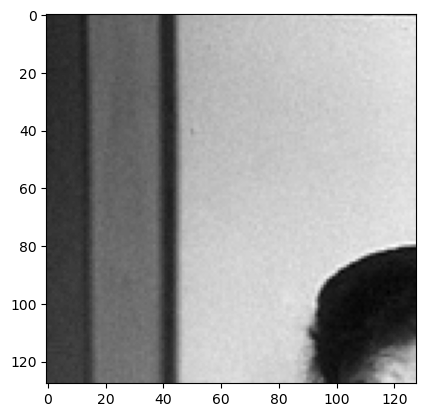

In [20]:
noise_var = 0.005  # more noise makes denoising harder; we suggest you keep this value but you can also experiment with more or less noise
train_chunk_size = 128  # depends on your hardware; larger chunks require more memory during gradient computation; we recommend 128

train_set = NoisyImageChunkDataset(img_files=train_img_files, noise_var=noise_var, chunk_size=train_chunk_size)
# for validation and testing, we do not have to split the images into chunks because we do not have to compute gradients
# the images have shape (321, 481) or (481, 321) so we crop them to (321, 321) to facilitate data loading
val_set = NoisyImageChunkDataset(img_files=val_img_files, noise_var=noise_var, chunk_size=321)
test_set = NoisyImageChunkDataset(img_files=test_img_files, noise_var=noise_var, chunk_size=321)

plt.imshow(train_set[0][0], cmap="gray")

In [21]:
batch_size = 10  # depends on your hardware

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [22]:
# more pooling layers and convolutional kernels increase the complexity of the U-Net (see lecture notes)
num_pool_layers = 5
chans = 32
device = "cpu"  # set to "cuda" or "cuda:0" if you have access to a GPU (e.g. via Google Colab)

model = Unet(
    in_chans=1,  # 1 input channel as we use grayscale images as input
    out_chans=1,  # 1 output channel as the model returns grayscale images
    num_pool_layers=num_pool_layers,
    chans=chans
)
model = model.to(device)

### Problem 2
Choose a suitable loss for training and implement the training loop. Be sure to also check the validation loss (or PSNR) every few epochs to be sure that your model does not overfit.

Hint: In deep learning it is often helpful to normalize the data before passing it through the model. In image-to-image tasks (such as denoising), we often also de-normalize the model output to map the pixels back into the original range. For example:
````
mean, std = mean(img_noisy), std(img_noisy)
img_noisy = (img-mean) / std
img_denoised = model(img_noisy)
img_denoised = img_denoised * std + mean
````
An intuition behind this is that the model can then receive and return images in a fixed range which makes learning easier. Feel free to train your model with and without normalization to see if it makes a difference.


In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # choose a suitable optimizer form torch.optim; we recommend to use the ADAM optimizer
criterion = torch.nn.CrossEntropyLoss()  # choose a suitable loss function from torch.nn

epochs = 10  # how many epochs to train
check_val_every_epochs = 5

# initialize the minimum validation loss to a large number
min_val_loss = float('inf')

# initialize the number of epochs with no improvement in validation loss
epochs_no_improve = 0

# set the maximum number of epochs with no improvement before stopping training
max_epochs_no_improve = 5

for e in range(epochs):
    for imgs_noisy, imgs_clean in tqdm.tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)
        mean = torch.mean(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
        std = torch.std(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
        imgs_noisy = (imgs_noisy-mean) / std
        imgs_noisy = imgs_noisy[None, :, :, :]
        imgs_noisy = imgs_noisy.permute(1,0,2,3)
        imgs_clean = imgs_clean[None, :, :, :]
        imgs_clean = imgs_clean.permute(1,0,2,3)
        imgs_denoised = model.forward(imgs_noisy)
        imgs_denoised[:,0,:,:] = imgs_denoised[:,0,:,:] * std + mean
        loss = criterion(imgs_denoised, imgs_clean)
        loss.backward()
        optimizer.step()

## DID NOT TEST THE VALIDATION BECAUSE OF THE TIME CONSTRAINTS HOWEVER IT SHOULD WORK SINCE SAME AS THE TEST PART!

    # if e % check_val_every_epochs == 0:
    #     # disable gradient computation for validation
    #     with torch.no_grad():
    #         model.eval()
    #         val_loss = 0
    #         for imgs_noisy, imgs_clean in tqdm.tqdm(val_loader, desc="Validation"):
    #             # TODO
    #             imgs_noisy = imgs_noisy.to(device)
    #             imgs_clean = imgs_clean.to(device)
    #             mean = torch.mean(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
    #             std = torch.std(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
    #             imgs_noisy = (imgs_noisy-mean) / std
    #             imgs_noisy = imgs_noisy[None, :, :, :]
    #             imgs_noisy = imgs_noisy.permute(1,0,2,3)
    #             imgs_clean = imgs_clean[None, :, :, :]
    #             imgs_clean = imgs_clean.permute(1,0,2,3)
    #             val_outputs = model(imgs_noisy)
    #             val_outputs[:,0,:,:] = val_outputs[:,0,:,:] * std + mean
    #             loss = criterion(val_outputs, imgs_clean)
    #             val_loss += loss.item()
    #         val_loss /= len(val_loader)
    #         model.train()
            
    #         # check if the validation loss has decreased
    #     if val_loss < min_val_loss:
    #         # update the minimum validation loss
    #         min_val_loss = val_loss

    #         # reset the number of epochs with no improvement
    #         epochs_no_improve = 0
    #     else:
    #         # increment the number of epochs with no improvement
    #         epochs_no_improve += 1

    #         # stop training if the maximum number of epochs with no improvement has been reached
    #         if epochs_no_improve == max_epochs_no_improve:
    #             print('Early stopping!')
    #             break

Training: 100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


### Problem 3
Test your model on the `test_loader`. Use suitable image metrics (e.g. PSNR, SSIM) to quantitatively assess the denoising performance of your model.

In [59]:
# TODO
mse = 0
model.eval()
for imgs_noisy, imgs_clean in tqdm.tqdm(test_loader, desc="Test"):
    with torch.no_grad():
        imgs_noisy = imgs_noisy.to(device)
        imgs_clean = imgs_clean.to(device)
        mean = torch.mean(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
        std = torch.std(imgs_noisy, (1,2)).unsqueeze(1).unsqueeze(2).broadcast_to(imgs_noisy.shape)
        imgs_noisy = (imgs_noisy-mean) / std
        imgs_noisy = imgs_noisy[None, :, :, :]
        imgs_noisy = imgs_noisy.permute(1,0,2,3)
        imgs_clean = imgs_clean[None, :, :, :]
        imgs_clean = imgs_clean.permute(1,0,2,3)
        imgs_denoised = model(imgs_noisy)
        imgs_denoised[:,0,:,:] = imgs_denoised[:,0,:,:] * std + mean
        loss = criterion(imgs_denoised, imgs_clean)
        mse += torch.mean((imgs_clean - imgs_denoised) ** 2)
    psnr = 10 * torch.log10(1 / mse)

Test: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


In [60]:
print(f"PSNR: {psnr.item()} dB")

PSNR: 6.716470241546631 dB
